# Advanced Statistics for Physics - Exam

## Neural Network

In [1]:
# load libraries
library(keras)
library(caret)
library(RColorBrewer)

Loading required package: lattice
Loading required package: ggplot2


In [2]:
# load dataset
background.path <- "data/background.csv"
signal.path     <- "data/MC_signal.csv"
data_lhcb.path  <- "data/data_lhcb.csv"


background <- read.csv(background.path, row.names=1) # label 0
signal     <- read.csv(signal.path, row.names=1)     # label 1

data_lhcb  <- read.csv(data_lhcb.path, row.names=1)  # real data

In [3]:
# keep only significant features

features <- c("Lambda_c_MM_F",      # mass Lambda_c 
              "lc_p_ProbNNp_F",     # prob Lambda_c p identified as a p 
              "lcZDecLSigma_F",     # Lambda_c z decay length over error 
              "lcstarZDecLSigma_F", # Lambda_c* z decay length over error
              "lcDecTime_F",        # Lambda_c decay time
              "lcstarDecTime_F",    # Lambda_c* decay time
              "lbDecTime_F",        # Lambda_b decay time
              "lcDecVerChi2_F",     # prob of Lambda_c Chi2 vertex
              "lcstarDecVerChi2_F", # prob of Lambda_c* Chi2 vertex
              "Lambda_b0_DIRA_OWNPV_F", # Lambda_0 DIRA of PV
              "pair0_3pi_F",        # pair mass pi_0 and pi_1 
              "pair1_3pi_F"         # pair mass pi_1 and pi_2
             )

signal     <- signal[features]
background <- background[features]

data_lhcb  <- data_lhcb[features]

In [4]:
#separation of the dataset into train and test set
#80% of the dataset is used for training

#signal
train.signal       <- signal[1:(as.integer(nrow(signal)*0.8)),]
train.label.signal <- replicate(nrow(train.signal),1)

test.signal        <- signal[(as.integer(nrow(signal)*0.8)+1):nrow(signal),]
test.label.signal  <- replicate(nrow(test.signal),1)

#background
train.background       <- background[1:(as.integer(nrow(background)*0.8)),]
train.label.background <- replicate(nrow(train.background),0)

test.background        <- background[(as.integer(nrow(background)*0.8)+1):nrow(background),]
test.label.background  <- replicate(nrow(test.background),0)

#final training and test set
train       <- rbind(train.signal,train.background)
train.label <- c(train.label.signal,train.label.background)
# shuffle data order in the training set
set.seed(20190630)
shuffle     <- sample(length(train.label))
train       <- train[shuffle,]
train.label <- train.label[shuffle]

test        <- rbind(test.signal,test.background)
test.label  <- c(test.label.signal,test.label.background)

# save the entire MC dataset to train the best model before making predictions on real data
MC       <- rbind(train, test)
MC.label <- c(train.label, test.label)

#scaling data for feed the NN (mean=0, std=1)
train.scaled <- train %>% scale()
train.label  <- as.numeric(train.label)

test.scaled  <- test %>% scale()
test.label   <- as.numeric(test.label)

MC.scaled    <- MC %>% scale()
MC.label     <- as.numeric(MC.label)

data_lhcb_scaled <- data_lhcb %>% scale()


In [5]:
# gridsearch over optipizer, loss function and activation function

OPT  <- c("SGD","RMSprop","Adam")
LOSS <- c("binary_crossentropy","squared_hinge")
OUT  <- c("sigmoid","softmax")

# list to save the results
Performance.1 <- list()

# loop over optimizer
for(OPTIMIZER in OPT){
    # loop over the loss function
    for(LOSS_FUNC in LOSS){
        # loop over the activation function
        for(OUTPUT_FUNC in OUT){
            
            # defining the model
            model <- keras_model_sequential() 

            model %>% 

                layer_dense(units = 5, input_shape = c(ncol(train)), activation = "sigmoid") %>%
                layer_dense(units = 1, activation= OUTPUT_FUNC)

            # compile the model
            model %>% compile(
                loss = LOSS_FUNC,
                optimizer = OPTIMIZER,
                metrics = c('accuracy')
            )
            
            # train the model
            history <- model %>% fit(
                train.scaled, 
                train.label,
            )
            
            # evaluate accuracy on the test set
            score <- model %>% evaluate(test.scaled, test.label)
            
            # save the results
            temp_perf   <- data.frame(OPTIMIZER, LOSS_FUNC, OUTPUT_FUNC, score$acc)
            Performance.1 <- rbind(Performance.1,temp_perf)      
            
        }
    }  
}

In [6]:
# print the results as a data.frame

Performance.1 <- as.data.frame(Performance.1)
rownames(Performance.1) <- NULL
names(Performance.1) <- c("Optimizer", "LossFunction", "ActivationFunction", "Accuracy")

Performance.1

Optimizer,LossFunction,ActivationFunction,Accuracy
<fct>,<fct>,<fct>,<dbl>
SGD,binary_crossentropy,sigmoid,0.90073282
SGD,binary_crossentropy,softmax,0.09926715
SGD,squared_hinge,sigmoid,0.10059960
SGD,squared_hinge,softmax,0.09926715
RMSprop,binary_crossentropy,sigmoid,0.91872084
RMSprop,binary_crossentropy,softmax,0.09926715
RMSprop,squared_hinge,sigmoid,0.09926715
RMSprop,squared_hinge,softmax,0.09926715
Adam,binary_crossentropy,sigmoid,0.91905397


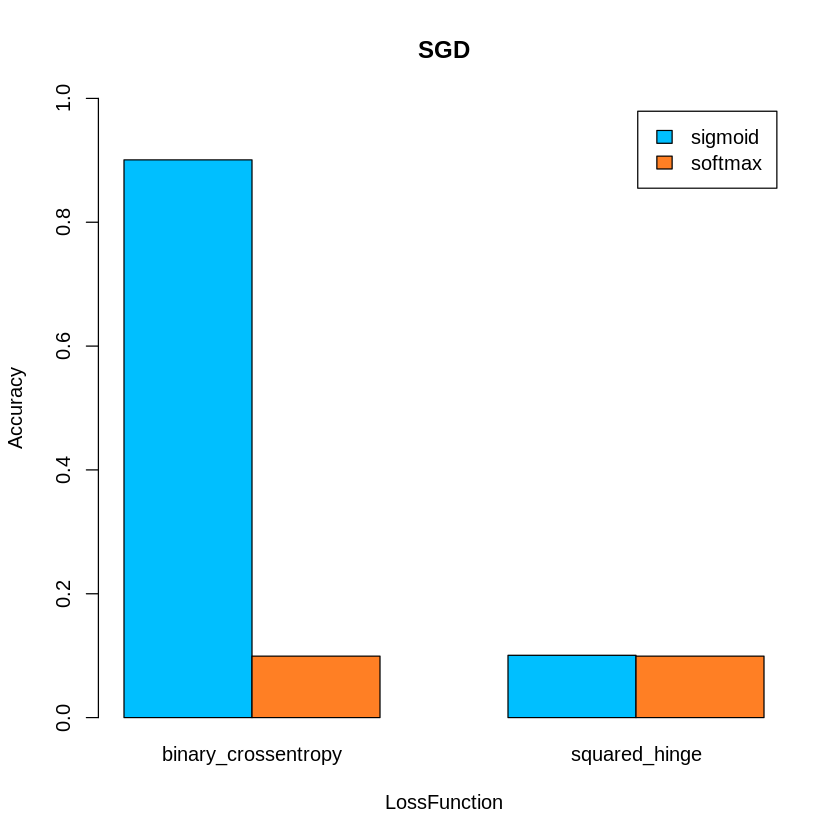

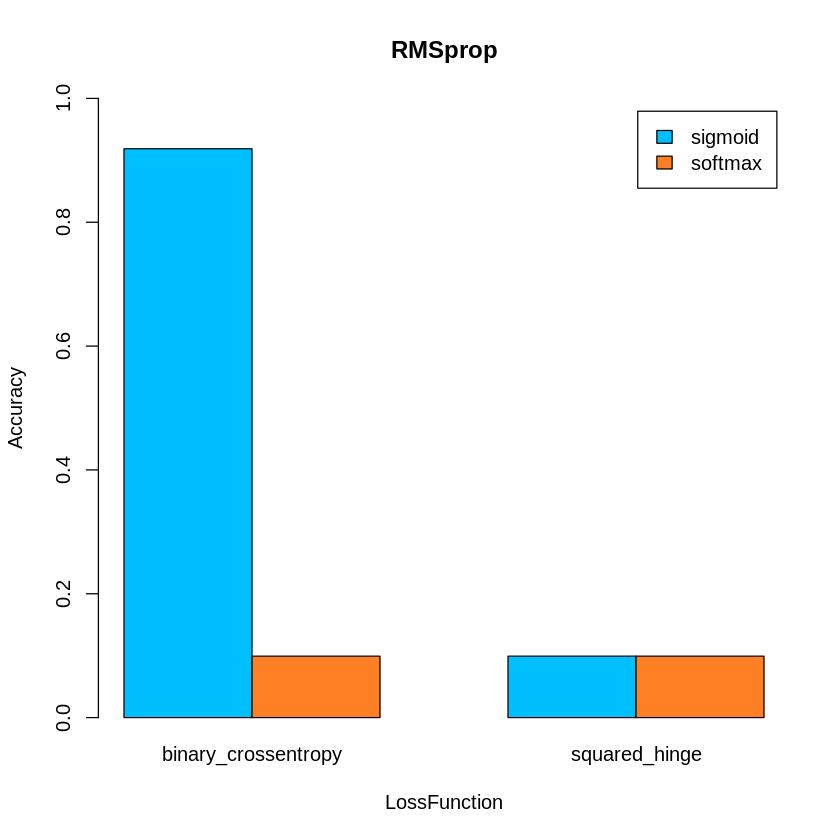

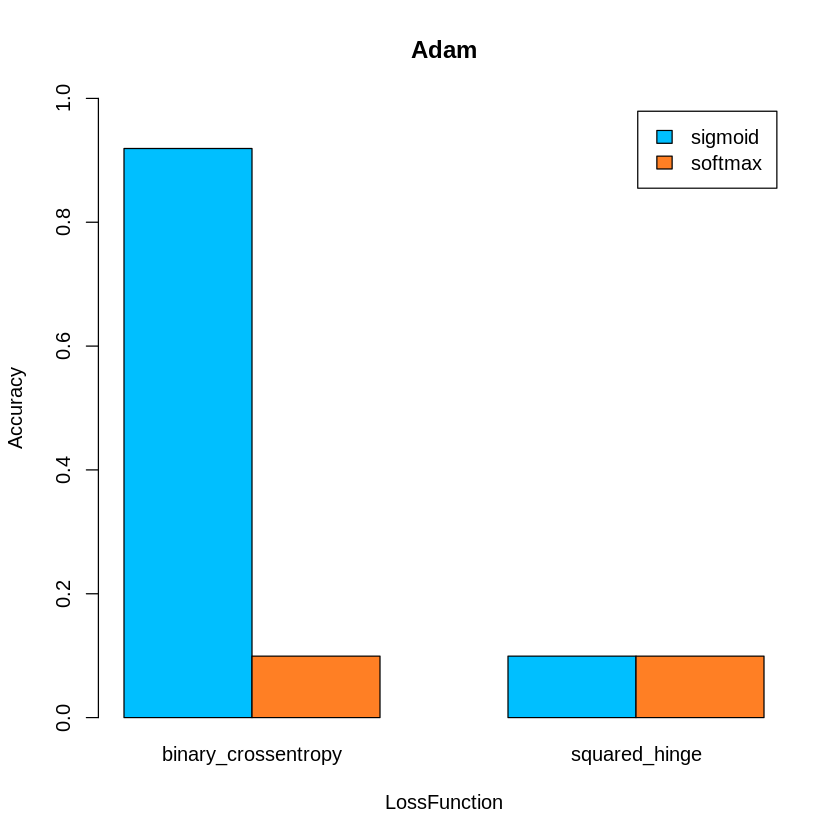

In [7]:
# plot the results and save them to file

for(name in OPT){
    barplot(Accuracy~ActivationFunction+LossFunction, subset=Optimizer == name, 
        data=Performance.1, legend=T, beside=T, col=c("deepskyblue", "chocolate1"), ylim=c(0,1), main=name)
    pdf(paste0("Figure/NN/accuracy_", name, ".pdf"))
    barplot(Accuracy~ActivationFunction+LossFunction, subset=Optimizer == name, 
        data=Performance.1, legend=T, beside=T, col=c("deepskyblue", "chocolate1"), ylim=c(0,1), main=name)
    dev.off()
}

In [8]:
# estracting the best parameter

Optim     <- toString(Performance.1$Optimizer[which.max(Performance.1$Accuracy)])
Lossfunc  <- toString(Performance.1$LossFunction[which.max(Performance.1$Accuracy)])
Actfunc   <- toString(Performance.1$ActivationFunction[which.max(Performance.1$Accuracy)])

In [9]:
# 1 hidden layer. Evaluate the performance as function of the number of hidden neuron

# data.frame to save the results
Performance.2 <- data.frame()

# loop over the number of unkits in the hidden layer
for(unit in c(1,2,3,10, 30, 50, 100, 150)){
    # defining the model
    model <- keras_model_sequential() 
    
    model %>% 

        layer_dense(units = unit , input_shape = c(ncol(train.signal)), activation = Actfunc) %>%
        layer_dense(units = 1, activation= Actfunc)

    # compile the model
    model %>% compile(
        loss = Lossfunc,
        optimizer = Optim,
        metrics = 'accuracy'
    )
 
    # train the model
    history <- model %>% fit(
        train.scaled, 
        train.label,
    )

    # evaluate accuracy on the test set
    score <- model %>% evaluate(test.scaled, test.label)
    # save results
    temp_perf   <- data.frame(unit, score$acc)
    Performance.2 <- rbind(Performance.2, temp_perf)
    
}

In [10]:
# print the results as a data.frame

Performance.2 <- as.data.frame(Performance.2)
rownames(Performance.2) <- NULL
names(Performance.2) <- c("Units", "Accuracy")

Performance.2

# extracting the best parameters
best.unit.h1 <- as.integer(Performance.2$Units[[which.max(Performance.2$Accuracy)]])
best.acc.h1  <- max(Performance.2$Accuracy)

Units,Accuracy
<dbl>,<dbl>
1,0.9007328
2,0.9007328
3,0.9007328
10,0.9210526
30,0.9197202
50,0.9193871
100,0.9157228
150,0.9190540


png 
  2

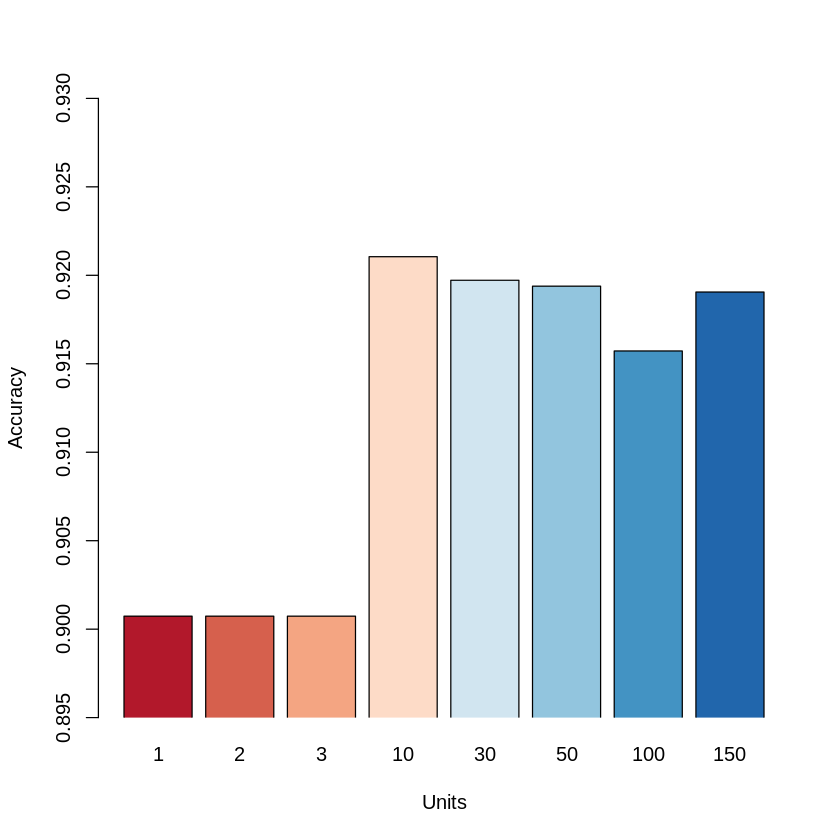

In [11]:
# barplot of the accuracy

barplot(Accuracy~Units, data=Performance.2, ylim=c(0.895,0.93), xpd=F, 
        col=brewer.pal(n = 8, name = "RdBu"))
pdf("Figure/NN/1_Layer_accuracy.pdf")
barplot(Accuracy~Units, data=Performance.2, ylim=c(0.895,0.93), xpd=F, 
        col=brewer.pal(n = 8, name = "RdBu"))
dev.off()

In [12]:
# 2 hidden layer

# data.frame to save the results
Performance.3 <- data.frame()

for(unit_h1 in c(5,10,15)){
    for(unit_h2 in c(5,10,15)){
             
        model <- keras_model_sequential() 
        model %>% 

            layer_dense(units = unit_h1, input_shape = c(ncol(train.signal)), activation = Actfunc) %>%
            layer_dense(units = unit_h2, input_shape = c(unit_h1), activation= Actfunc) %>%
            layer_dense(units = 1, activation= Actfunc)


        model %>% compile(
            loss = Lossfunc,
            optimizer = Optim,
            metrics = 'accuracy'
        )

        history <- model %>% fit(
            train.scaled, 
            train.label,
        )

        # evaluate accuracy on the test set
        score <- model %>% evaluate(test.scaled, test.label)
        # save the results
        temp_perf   <- data.frame(unit_h1, unit_h2, score$acc)
        Performance.3 <- rbind(Performance.3, temp_perf)

    }
}

In [13]:
# print the results as data.frame
Performance.3 <- as.data.frame(Performance.3)
rownames(Performance.3) <- NULL
names(Performance.3) <- c("Unit_h1", "Unit_h2", "Accuracy")

Performance.3

# extracting the best parameters
best.unit1.h2 <- as.integer(Performance.3$Unit_h1[[which.max(Performance.3$Accuracy)]])
best.unit2.h2 <- as.integer(Performance.3$Unit_h2[[which.max(Performance.3$Accuracy)]])
best.acc.h2  <- max(Performance.3$Accuracy)

Unit_h1,Unit_h2,Accuracy
<dbl>,<dbl>,<dbl>
5,5,0.9197202
5,10,0.9193871
5,15,0.9183878
10,5,0.9183878
10,10,0.9190540
10,15,0.9193871
15,5,0.9157228
15,10,0.9190540
15,15,0.9180546


In [14]:
# more than 2 hidden layer

# defining the model
model <- keras_model_sequential() 

model %>% 

    layer_dense(units = 10, input_shape = c(ncol(train.signal)), activation = Actfunc) %>%
    layer_dense(units = 5, input_shape = c(10), activation= Actfunc) %>%
    layer_dense(units = 3, input_shape = c(5), activation= Actfunc) %>%
    layer_dense(units = 2, input_shape = c(3), activation= Actfunc) %>%
    layer_dense(units = 1, activation= Actfunc)

# compile the model
model %>% compile(
    loss = Lossfunc,
    optimizer = Optim,
    metrics = 'accuracy'
)

# train the model
history <- model %>% fit(
    train.scaled, 
    train.label,
)

# evaluate accuracy on the test set
score <- model %>% evaluate(test.scaled, test.label)
score

best.acc.h4 <- score$acc

$loss
[1] 0.2455234

$acc
[1] 0.9007328

In [15]:
#summary 
cat ("Best accuracy with one hidden layer: ", best.acc.h1," obtained with: ", best.unit.h1, "hidden units \n")
cat ("Best accuracy with two hidden layer: ", best.acc.h2," obtained with: ", best.unit1.h2, "unit of fist layer and ",best.unit2.h2," on the second \n")
cat ("Best accuracy with four hidden layer: ", best.acc.h4)

Best accuracy with one hidden layer:  0.9210526  obtained with:  10 hidden units 
Best accuracy with two hidden layer:  0.9197202  obtained with:  5 unit of fist layer and  5  on the second 
Best accuracy with four hidden layer:  0.9007328

In [26]:
# building and training the best model on train set, and evaluate performance on the test set
model <- keras_model_sequential() 
model %>% 

    layer_dense(units = 10, input_shape = c(ncol(train.signal)), activation = Actfunc) %>%
    layer_dense(units = 1, activation= Actfunc)


model %>% compile(
    loss = Lossfunc,
    optimizer = Optim,
    metrics = 'accuracy'
)

history <- model %>% fit(
    train.scaled, 
    train.label,
    validation_data = list(test.scaled, test.label)
)


png 
  2

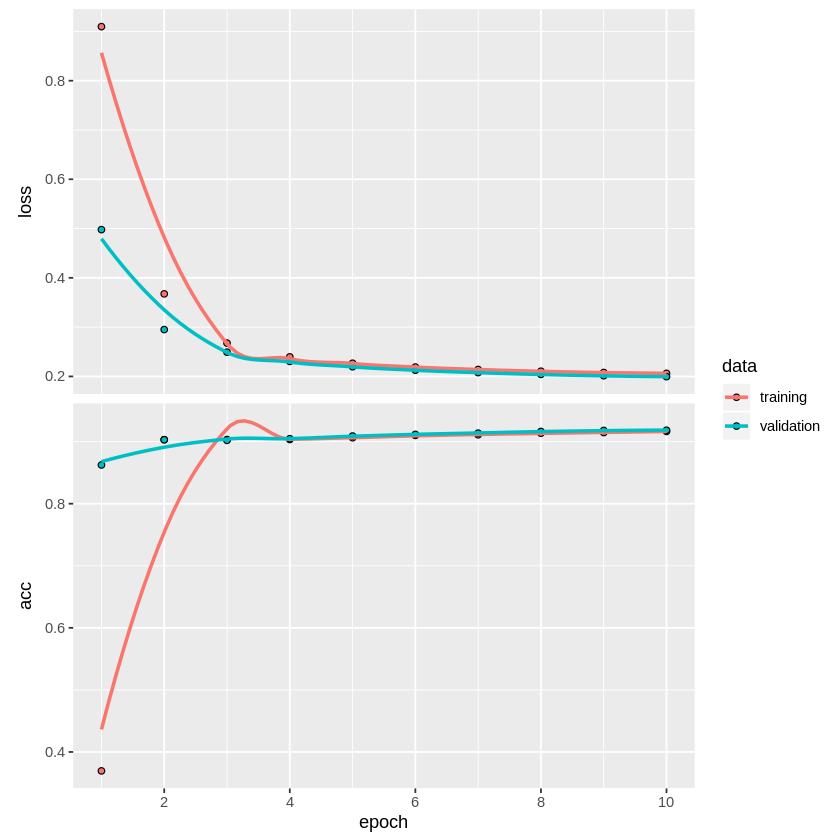

In [27]:
# plot the accuracy as function of the epoch on training and test set
plot(history)
pdf("Figure/NN/accuracy_final.pdf")
plot(history)
dev.off()

In [18]:
# building and training the best model on the whole MC
model <- keras_model_sequential() 
model %>% 

    layer_dense(units = 10, input_shape = c(ncol(train.signal)), activation = Actfunc) %>%
    layer_dense(units = 1, activation= Actfunc)


model %>% compile(
    loss = Lossfunc,
    optimizer = Optim,
    metrics = 'accuracy'
)

history <- model %>% fit(
    MC.scaled, 
    MC.label,
)


In [19]:
summary(model)

________________________________________________________________________________
Layer (type)                        Output Shape                    Param #     
dense_74 (Dense)                    (None, 10)                      130         
________________________________________________________________________________
dense_75 (Dense)                    (None, 1)                       11          
Total params: 141
Trainable params: 141
Non-trainable params: 0
________________________________________________________________________________


In [20]:
# prediction on Lhcb_data

predict.lhcb         <- model %>% predict_classes(data_lhcb_scaled)
data_lhcb.signal     <- data_lhcb[which(predict.lhcb==1),]
data_lhcb.background <- data_lhcb[which(predict.lhcb==0),]

data_lhcb.signal     <- as.data.frame(data_lhcb.signal)
data_lhcb.background <- as.data.frame(data_lhcb.background)

cat("# of event with signal found: ", nrow(data_lhcb.signal))
cat("\n# of event without signal found: ", nrow(data_lhcb.background))

# of event with signal found:  13949
# of event without signal found:  458801

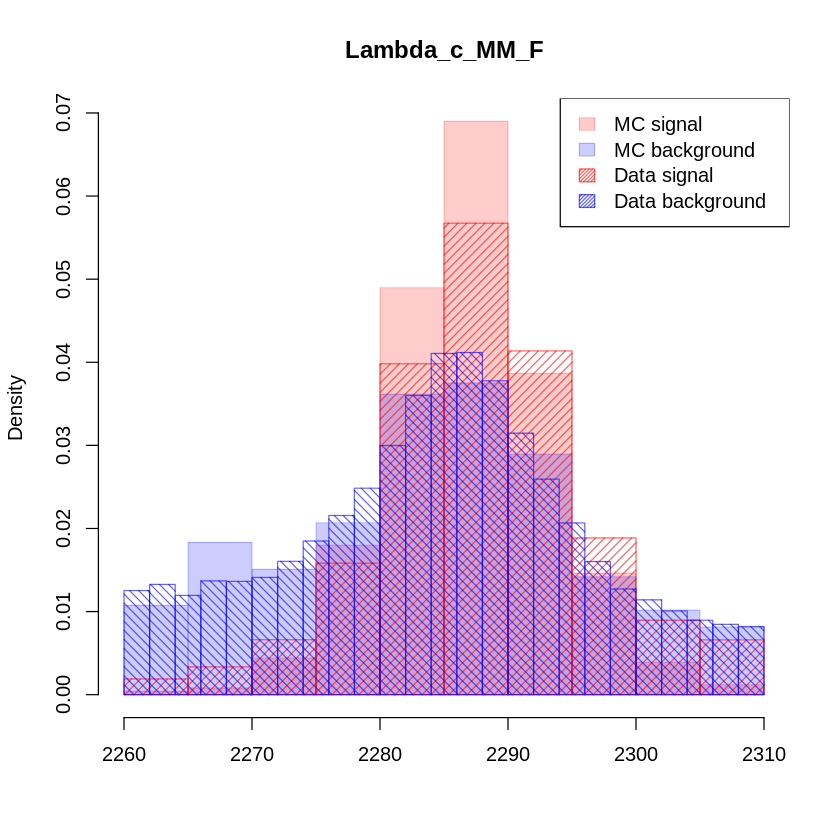

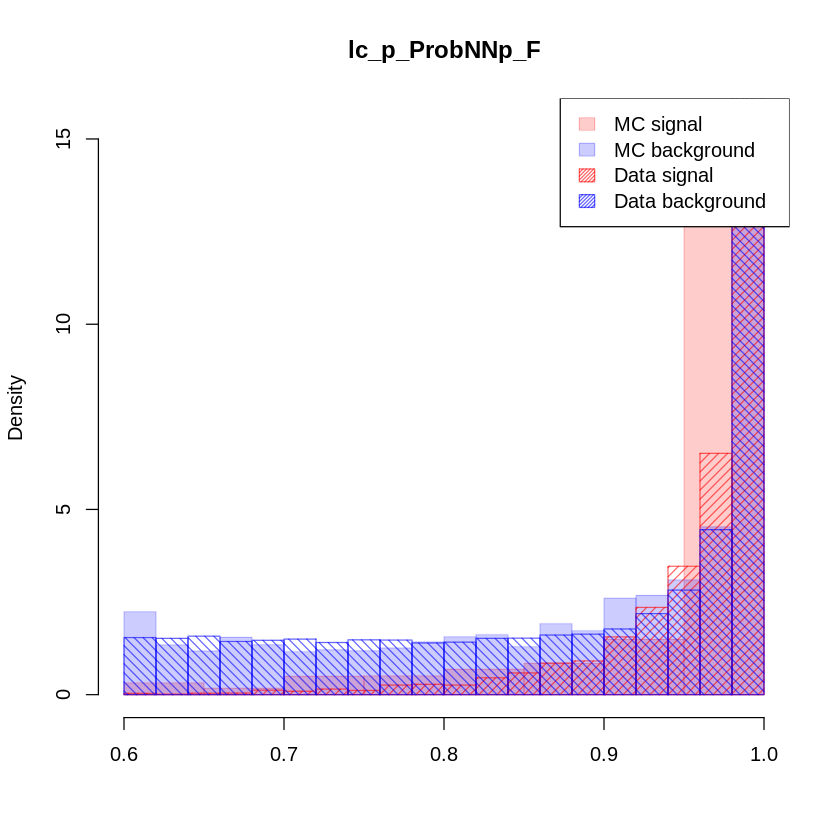

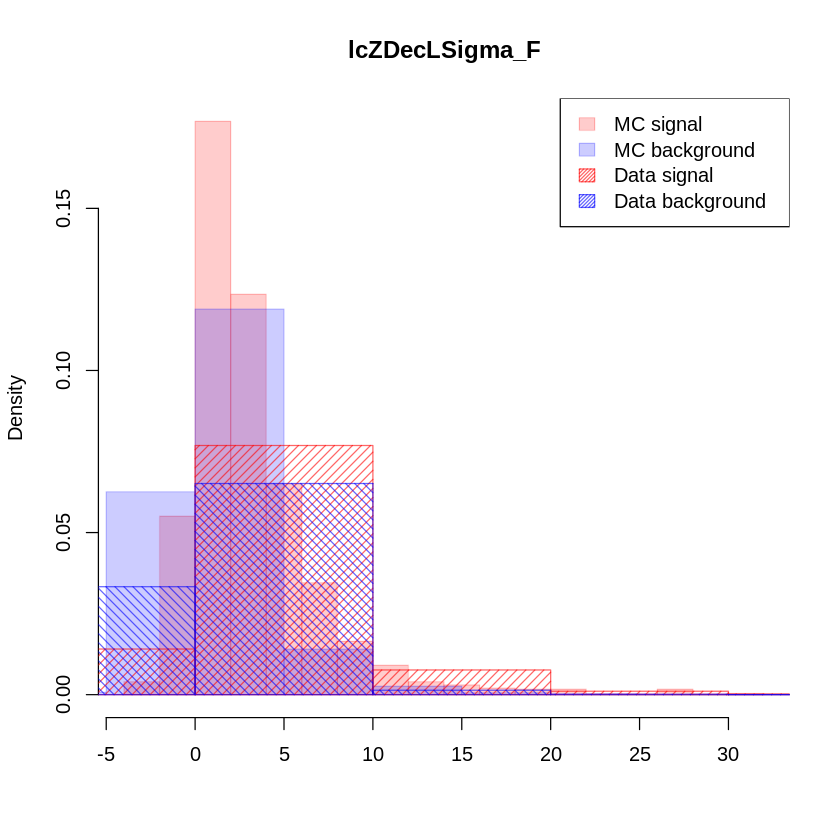

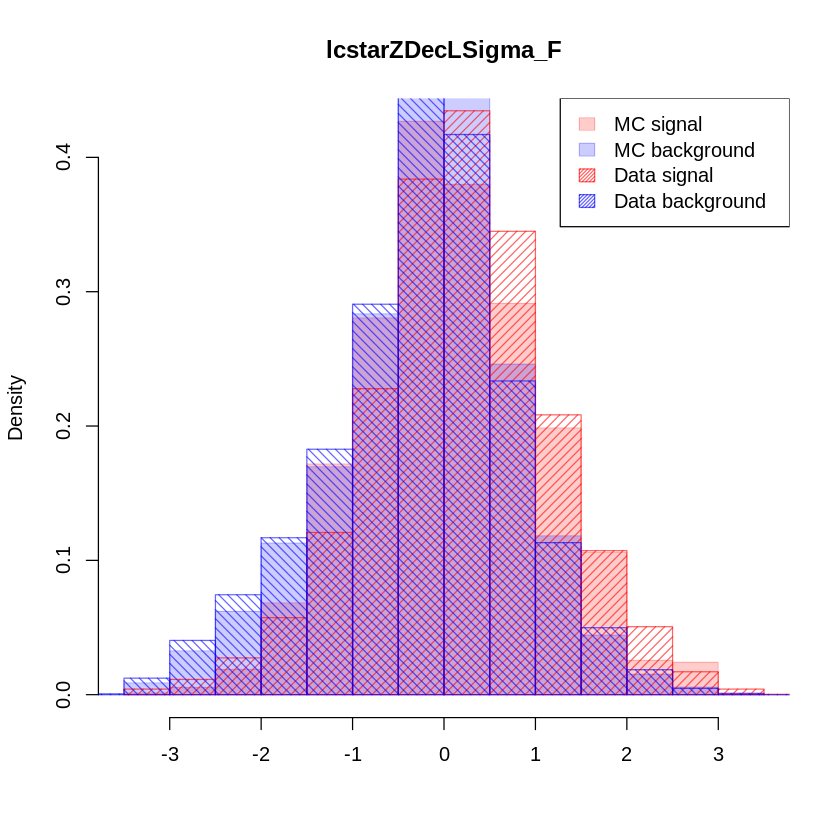

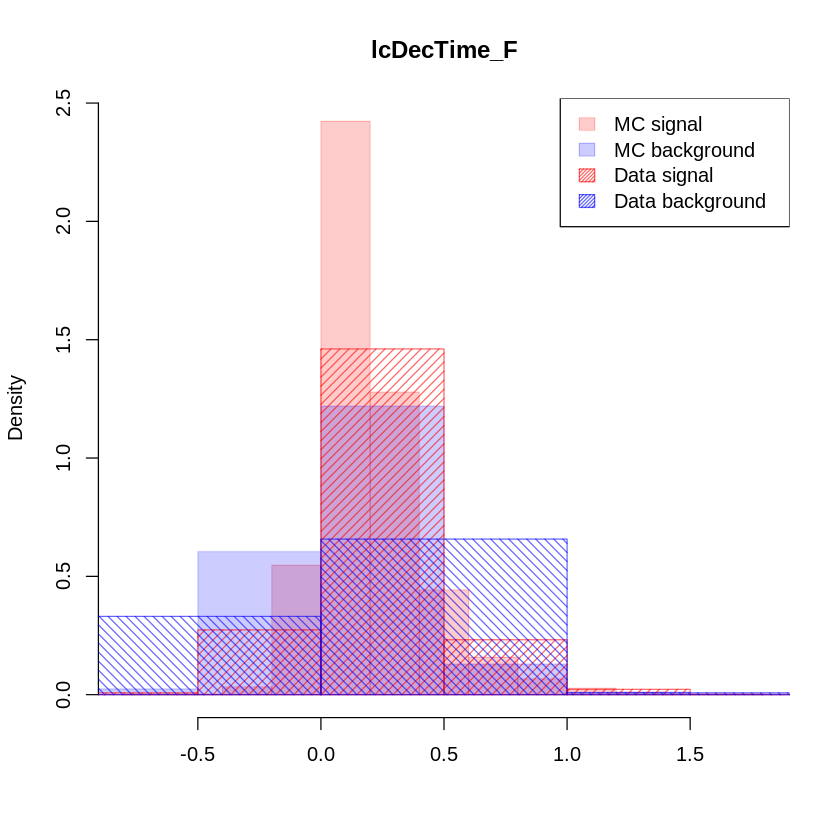

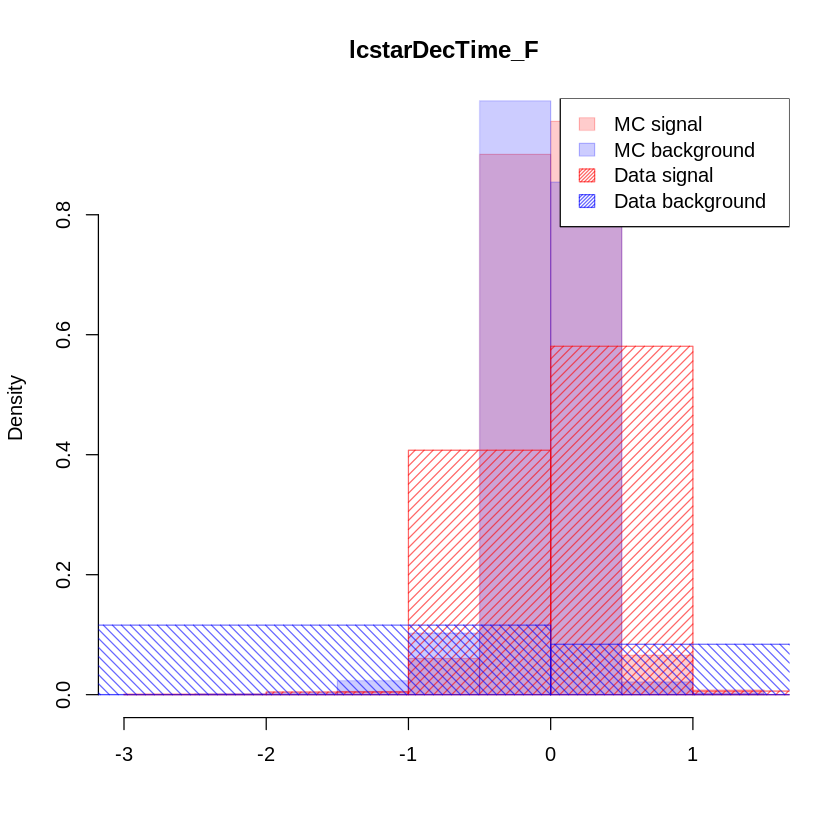

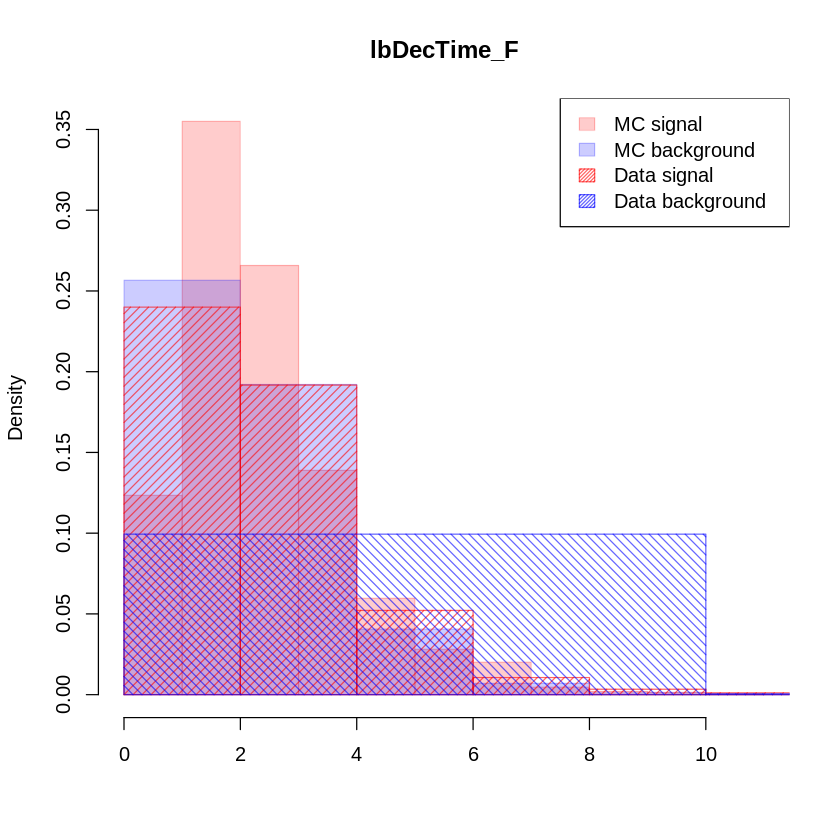

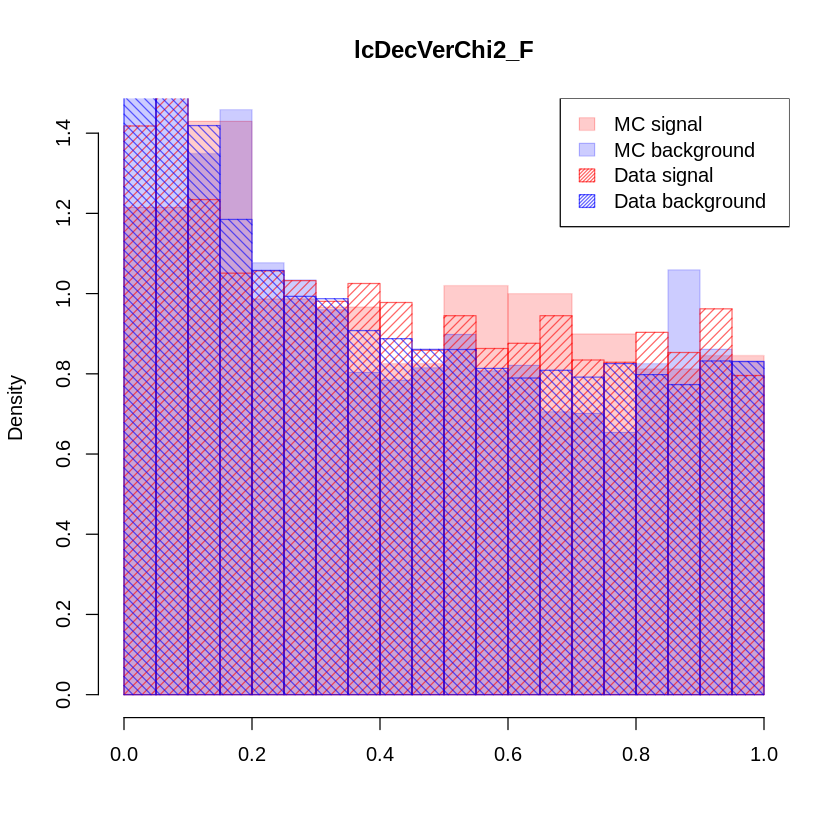

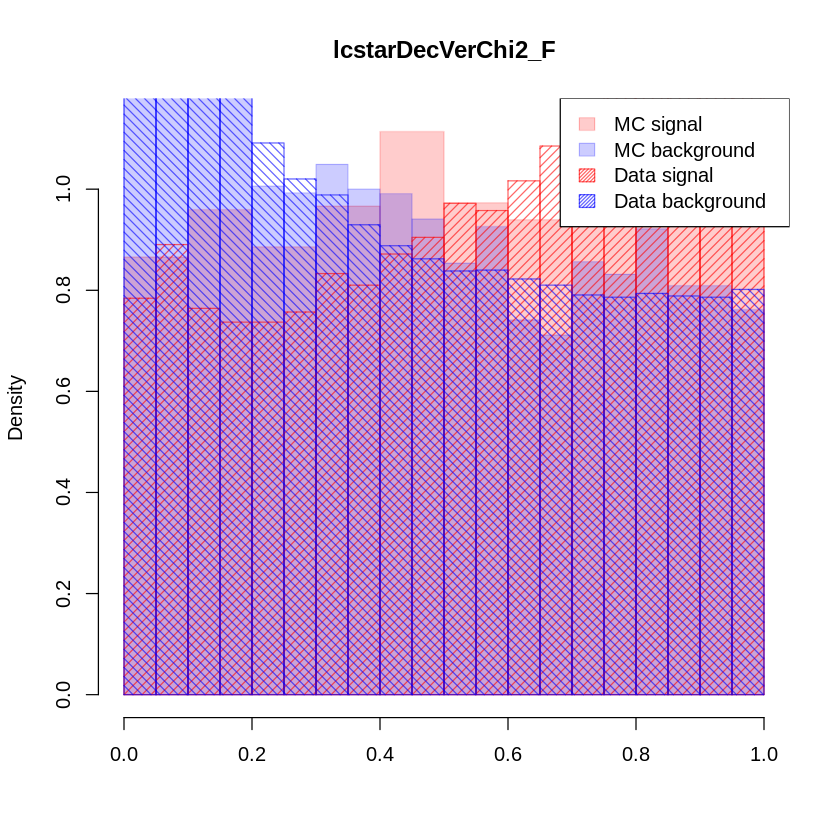

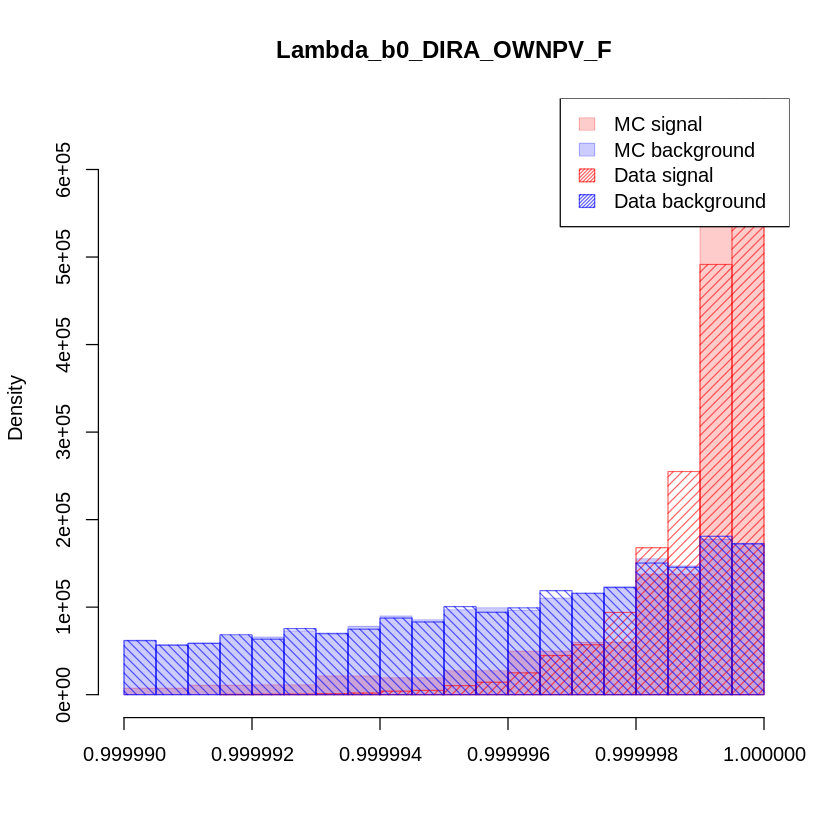

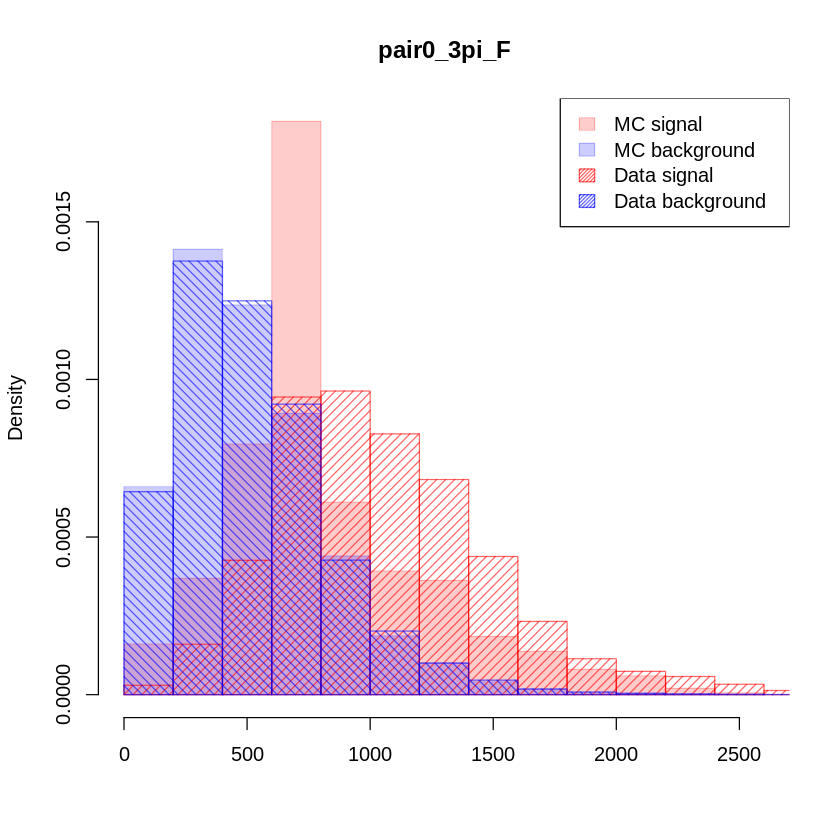

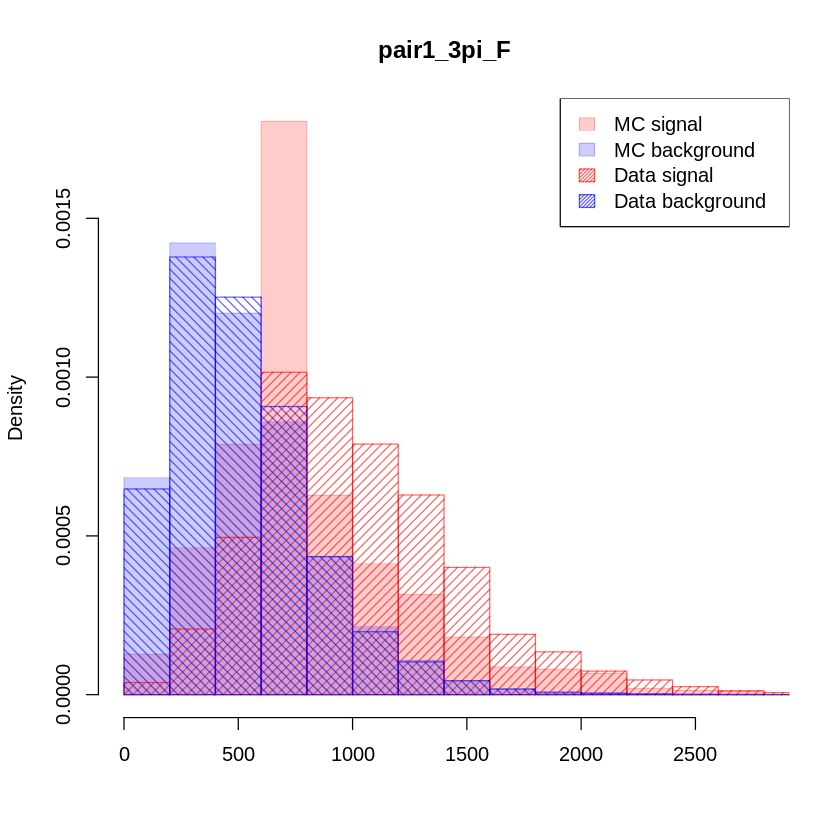

In [21]:
# plot histograms of MC and data distribution, both for signal and background
legend = c("MC signal", "MC background", "Data signal", "Data background")
col  = c(rgb(1,0,0,0.2), rgb(0,0,1,0.2), rgb(1,0,0,0.6), rgb(0,0,1,0.6))

for(f in features){
    hist(signal[[f]],     freq=F, col=col[1], border=col[1], main=f, xlab="")
    hist(background[[f]], freq=F, col=col[2], border=col[2], add=T)
    hist(data_lhcb.signal[[f]], freq=F, col=col[3], border=col[3], density=20, add=T)
    hist(data_lhcb.background[[f]], freq=F, col=col[4], border=col[4], density=20, angle=-45, add=T)
    legend(x="topright", legend=legend, col=col, fill=col, border=col, density=c(NA,NA, 50,50))
    
}

In [22]:
# save some significative plots
features.selected <- c("Lambda_c_MM_F", "lc_p_ProbNNp_F", "Lambda_b0_DIRA_OWNPV_F", "pair0_3pi_F", "pair1_3pi_F")
legend = c("MC signal", "MC background", "Data signal", "Data background")
col  = c(rgb(1,0,0,0.2), rgb(0,0,1,0.2), rgb(1,0,0,0.6), rgb(0,0,1,0.6))

for(f in features.selected){
    pdf(paste0("Figure/NN/", f, ".pdf"))
    hist(signal[[f]],     freq=F, breaks=15, col=col[1], border=col[1], main=f, xlab="")
    hist(background[[f]], freq=F, breaks=15, col=col[2], border=col[2], add=T)
    hist(data_lhcb.signal[[f]], freq=F, breaks=15, col=col[3], border=col[3], density=20, add=T)
    hist(data_lhcb.background[[f]], freq=F, breaks=15, col=col[4], border=col[4], density=20, angle=-45, add=T)
    legend.position <- ifelse(f=="Lambda_b0_DIRA_OWNPV_F" | f=="lc_p_ProbNNp_F", "top", "topright")
    legend(x=legend.position, legend=legend, col=col, fill=col, border=col, density=c(NA,NA, 50,50))
    dev.off()
    
}